In [11]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)
assert "2." in tf.__version__, "This notebook is designed to run on TensorFlow 2.x"


TensorFlow version: 2.14.0


In [12]:
# Additional imports here
import os
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
from tqdm import tqdm   # For progress bar

In [13]:
# Mount drive for data access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Initialize directories
gan_data_dir = '/content/drive/My Drive/ML-GroupProject/Processed_Data/GAN_Training'

classifier_train_dir = '/content/drive/My Drive/ML-GroupProject/Processed_Data/Classifier_Training'

classifier_test_dir = '/content/drive/My Drive/ML-GroupProject/Processed_Data/Classifier_Testing'

# Directory for saving generated images
fake_dir = './generated_images'
os.makedirs(fake_dir, exist_ok=True)

In [14]:
# Load dataset for GAN Training

batch_size = 32  # Adjust as needed

# Function to normalize images
def normalize_image(image):
    # Normalize the images to [-1, 1]
    image = (image - 127.5) / 127.5
    return image

# Load the dataset
gan_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    gan_data_dir,
    label_mode=None,        # No labels needed as this is unsupervised learning
    image_size=(256, 256),  # Images are already of this size
    batch_size=batch_size,
    shuffle=True
).map(normalize_image).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 3464 files belonging to 1 classes.


In [15]:
# Define the Generator architecture

def make_generator_model(noise_dim):
    model = tf.keras.Sequential()

    # Start with a dense layer that reshapes into 8x8x1024 tensor
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 1024)))  # Reshaping into a 3D tensor

    # Deconvolutional layers
    # Upscale to 16x16
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upscale to 32x32
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upscale to 64x64
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upscale to 128x128
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final layer: Upscale to 256x256
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))  # 1 filter for grayscale, 3 for RGB

    return model



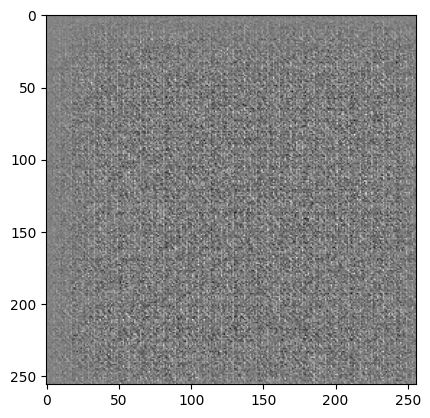

In [17]:
# Use the (as of yet untrained) generator to create an image

generator = make_generator_model(100)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [18]:
# Define Discriminator architecture

def make_discriminator_model():
    model = tf.keras.Sequential()

    # Input layer: 256x256x1
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(256, 256, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  # Used to prevent overfitting. Random set of neurons on each pass wont be used

    # Downsampling to 128x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsampling to 64x64
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())  # Provides more stable outputs, perfect for feature extracting!!!
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    # Downsampling to 32x32
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and final dense layer for classification
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [19]:
# Use the (as yet untrained) discriminator to classify the generated image as real or fake.

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[1.4266473e-05]], shape=(1, 1), dtype=float32)


In [20]:
# Define loss functions

# Loss function for evaluating adversarial performance
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [21]:
# Setup save checkpoints

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
# Function for viewing saving generated images

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(os.path.join(image_dir, f'image_at_epoch_{epoch:04d}.png'))
    plt.show()

In [24]:
# Setup training loop

def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Train function
def train(dataset, epochs, save_interval):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm(dataset):
            train_step(image_batch)

        # At the end of each save_interval, generate and save images, and save the model
        if (epoch + 1) % save_interval == 0:
            # Produce images for monitoring progress
            generate_and_save_images(generator, epoch + 1, seed)

            # Save the model
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [26]:
# Final setup variables

EPOCHS = 50                     # Number of epochs. Adjust as needed.
noise_dim = 100                 # Adjust as needed
num_examples_to_generate = 16   # Adjust as needed

# Seed for monitoring progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Start the training
train(gan_dataset, EPOCHS)